In [ ]:
!pip install --upgrade datasets

In [1]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import TensorDataset, DataLoader
import torch
from tqdm.auto import tqdm
import copy
from torch import nn
import numpy as np
import gc
import matplotlib.pyplot as plt

In [ ]:
datasets = load_dataset("huggingartists/xxxtentacion")

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenized_dataset = datasets.map(
    lambda x: tokenizer(
        x['text'],
        padding='max_length',
        max_length=512,
        truncation=True
    ),
    batched=True
)

In [ ]:
train_dataset = TensorDataset(torch.tensor(tokenized_dataset['train']['input_ids']),
                              torch.tensor(tokenized_dataset['train']['attention_mask']))
train_dataloader = DataLoader(train_dataset, batch_size=8)

In [5]:
def generate_sample(model, tokenizer, device, prompt=""):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=100,
            do_sample=True,
            top_k=50,
            temperature=1,
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(output[0], skip_special_tokens=True)

def train_GPT(model, train_dataloader, device, epochs=5):
    prompt = """
    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music
    """
    model = copy.deepcopy(model)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters())

    losses = []
    style_samples  = []
    perplexity = []

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        losses_per_epoch = []

        progress_bar = tqdm(train_dataloader, desc=f'Epoch: {epoch + 1}')
        for batch in progress_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            losses_per_epoch.append(loss.item())
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = np.mean(losses_per_epoch)
        losses.append(avg_loss)

        perplex = np.exp(avg_loss)
        perplexity.append(perplex)
        sample = generate_sample(model, tokenizer, device, prompt)
        style_samples.append(sample)

        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {avg_loss:.4f} | Perplexity: {perplex:.4f}")
        print("Generated Sample:")
        print(sample + "\n")


    return model, losses, perplexity

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()
model = GPT2LMHeadModel.from_pretrained('gpt2')
train_model, loss, preplex = train_GPT(model, train_dataloader, device, 10)

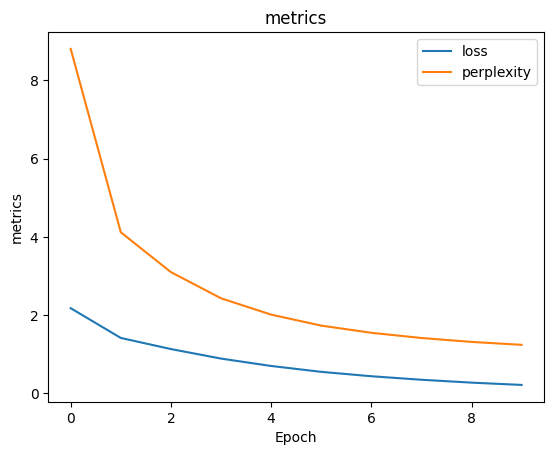

In [7]:
plt.plot(loss, label='loss')
plt.plot(preplex, label='perplexity')
plt.title('metrics')
plt.xlabel('Epoch')
plt.ylabel('metrics')
plt.legend()

In [8]:
prompt = """
stop repeating the same words, and answer naturally
question: Lets talk about music
"""
sample = generate_sample(train_model, tokenizer, device, prompt)
print(sample)


stop repeating the same words, and answer naturally
question: Lets talk about music
We as a nation give rise to this man
This world is so ice, I cannot understand it
My anxiety and troubles over people who never gave a fucking care
Im charging and putting the people down to where they’re nowhere 
This soothes me, I feel my anxiety and troubles over people who never gave a fucking care 
This soothes me, I feel my anxiety and troubles


In [9]:
output_dir = "/content/save"
train_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Модель сохранена в {output_dir}")

Модель сохранена в /content/save


In [10]:
!zip -r model.zip /content/save/
from google.colab import files
files.download('model.zip')

  adding: content/save/ (stored 0%)
  adding: content/save/special_tokens_map.json (deflated 74%)
  adding: content/save/model.safetensors (deflated 7%)
  adding: content/save/merges.txt (deflated 53%)
  adding: content/save/generation_config.json (deflated 24%)
  adding: content/save/vocab.json (deflated 68%)
  adding: content/save/config.json (deflated 51%)
  adding: content/save/tokenizer_config.json (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>